##### Set up screen wide view

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Import libraries and modules

In [2]:
##Import libraries
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

In [3]:
##Import functions
from objectGenerationRiver_func import*
from GlobalConstants import * 
from readImputParam import readProcessparam, microplasticData,readCompartmentData
from dilutionVol_calculator_func import*
import RC_GeneratorRiver
from RC_estimation_function import*
from reshape_RC_df_fun import*
from fillRCmatrixInteractionsTransport_func import*
from fillRCinteractionMatrices_func import*
from fillInteractions_df_fun import*
from celluloid import Camera
from cycler import cycler
%matplotlib inline

# Import input files

In [4]:
#Import process parameters
process_df= readProcessparam ("process_paramRiver.txt")
#Import MP parameters (radius, volume, etc) Same way
MP_prop = microplasticData("microplasticsSizeClass.txt")
#Import compartment info
compartments_prop = readCompartmentData("compartmentsGenericRiverSec_prop.txt")
#Add river section depth field
RSdepth = []
for row in range(len(compartments_prop)):
        RSdepth.append(round(sum(compartments_prop.depth_m[0:4]),2))
compartments_prop["depthRS_m"]=RSdepth

In [5]:
process_df

,ID,compartment,aggState,alpha,t_half_d,t_frag_d,t_biof_growth_d
0,1,1,A,0.01,5000,36.5,10
1,2,1,B,NaN,50000,NAN,10
2,3,1,C,0.02,25000,73.0,10
3,4,1,D,NaN,100000,NAN,10
4,5,2,A,0.01,5000,365,30
5,6,2,B,NaN,50000,NAN,30
6,7,2,C,0.02,25000,730,30
7,8,2,D,NaN,100000,NAN,30
8,9,3,A,0.01,5000,365,300
9,10,3,B,NaN,50000,NAN,300


In [6]:
MP_prop

,ID,name,composition,density_kg_m3,MPshape,sizeBin,diameter_um,length_a_um,length_b_um,length_c_um
0,1,MP1,PE,980,sphere,a,0.1,0,0,0
1,1,MP1,PE,980,sphere,b,1.0,0,0,0
2,1,MP1,PE,980,sphere,c,10.0,0,0,0
3,1,MP1,PE,980,sphere,d,100.0,0,0,0
4,1,MP1,PE,980,sphere,e,1000.0,0,0,0
5,2,MP2,PP,850,fibre,a,0.1,10,0,0
6,2,MP2,PP,850,fibre,b,1.0,10,0,0
7,2,MP2,PP,850,fibre,c,10.0,10,0,0
8,2,MP2,PP,850,fibre,d,100.0,10,0,0
9,2,MP2,PP,850,fibre,e,1000.0,10,0,0


In [7]:
compartments_prop

,riverSection,nameRS,compartment,compType,depth_m,length_m,volume_m3,width_m,G,T_K,vFlow_m_s,SPM_mgL,depthRS_m
0,0,RS0,1,surface,0.10,50000,400000.0,80,10,287.15,1.3,30,5.42
1,0,RS0,2,flowingWater,4.90,50000,19600000.0,80,10,287.15,1.3,30,5.42
2,0,RS0,3,stagnantWater,0.40,50000,1600000.0,80,10,287.15,1.3,30,5.42
3,0,RS0,4,sediment,0.02,50000,80000.0,80,10,287.15,1.3,30,5.42
4,1,RS1,1,surface,0.10,50000,400000.0,80,10,287.15,1.3,30,5.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,18,RS18,4,sediment,0.02,50000,80000.0,80,10,287.15,1.3,30,5.42
76,19,RS19,1,surface,0.10,50000,400000.0,80,10,287.15,1.3,30,5.42
77,19,RS19,2,flowingWater,4.90,50000,19600000.0,80,10,287.15,1.3,30,5.42
78,19,RS19,3,stagnantWater,0.40,50000,1600000.0,80,10,287.15,1.3,30,5.42


# Model set up

In [8]:
#RIVER COMPARTMENTS
compartments = ["Surface Water", "Flowing Water", "Stagnant Water", "Sediment"]
riverComp = ["1", "2", "3", "4"]

In [9]:
#MICROPLASTICS FORMS 
MPforms = ["A", "B", "C", "D"]
MPformslabels = ["Free", "Heteroaggregated", "Biofiolm-covered", "Biofilm-heteroaggregated"]

In [10]:
#SIZE BINS
sizeBin =["a", "b", "c", "d", "e"]
sizeBinLabel = ["0.1um", "1um","10um", "100um", "1000um"]# Detection limit for MPs via Fourier Transform Infrared Spectroscopy is 20um

In [11]:
#MPS RIVER PROCESSES (FATE AND TRANSPORT) LIST
processList = ["degradation", "fragmentation", "heteroagg", "breakup", "settling","rising", "advection", "mixing", "biofilm", "resusp", "burial","sedTransport", "defouling"]

In [12]:
#RIVER SECTIONS
numberRS=len (compartments_prop)/len(riverComp)
listRS = [*range(0,int(numberRS),1)]
riverSect = [str(item) for item in listRS]
riverLengths = [str(it) for it in compartments_prop["length_m"]]
riverSectLength= riverLengths[0::4]
RS_cumLength_m =[]
for d in range(len(riverSectLength)):
    if d==0:
        RS_cumLength_m.append(float(riverSectLength[d]))
    else:
        RS_cumLength_m.append(float(riverSectLength[d])+float(RS_cumLength_m[d-1]))

## Define run parameters
- Solver (Dynamic). SteadyState under developement
- mode (Standard). Monthly under developement
- mode2 (Timelimit or raw): "Timelimit" mode sets up a time limit of 30min on the processes that exceeds that speed, while "raw" mode leaves the rate constant as calcualted. The raw version can straing the solver due to time.
- record (True or False) : if "True" the results, RC and intercations dataframes will be recorded in the Results folder.

In [13]:
SOLVER = "Dynamic" 
mode = "Standard" 
mode2 = "Timelimit" 
record = "True"

## Define scenario 
- composition: define MP composition to study. The composition is defined in the microplastics imput file microplasticsSizeClass.txt. Examples given in such file: PE, PA and PVC.
- imputMP: Define imput location and wich MP form is emmited by indicating the river section number, river compartment number, MP aggregation state and size bin: ex. 02Ae (RS=0:1, comp= 2:flowing water, MPtype:A:FreeMP, sizeBin:e:1000um)
- imputFlow: define number of particles per minute entering the system
- imputPulse: define number of particles entering the systems in a pulse (if any)

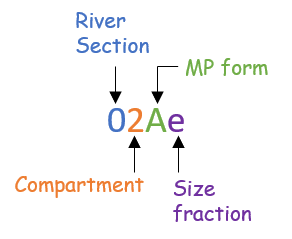

In [14]:
composition = "PVC"
imputMP= "02Ae"
imputFlow=100 
imputPulse=0

## Set simulation time:
- t0: starting time (seconds)
- daysSimulation: total length of simulation (days)
- stepSize (seconds)

In [15]:
t0 = 0 
daysSimulation = 365
tmax = 24*60*daysSimulation*60 
sec_day = 24*60*60
stepSize= 60*60*24 #time step of 1day
timesteps = int(sec_day*daysSimulation/stepSize) 
t_span = np.linspace(0, tmax, int(timesteps)+1, dtype=int)

## Define model run results file name

In [16]:
#Set up current date label#
from datetime import datetime, timedelta
date_time_str = '2020-01-01 00:00'
DayStart = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
LastDay = DayStart + timedelta(minutes=tmax)
date = DayStart
daterun = date.today()
daterun_label = daterun.strftime("%Y_%m_%d")

In [17]:
if imputFlow !=0:
    runtitle= daterun_label+ "_GenericRiver_" + composition +"_inflow_"+ imputMP+"_"+str(imputFlow)+"part_s_"+ mode2+"_TestRun"
else:
    runtitle= daterun_label+"_GenericRiver_" + composition +"_pulse_"+ imputMP+"_"+str(imputPulse)+"part_s_"+ mode2+"_TestRun"
runtitle

'2021_11_11_GenericRiver_PVC_inflow_02Ae_100part_s_Timelimit_TestRun'

## Generate list of species (combination of river section-compartment-MPform-sizeFraction)

In [18]:
#Generate COMBINATIONS
combinations = list(itertools.product(riverSect,riverComp,MPforms,sizeBin))
#Generate raw list of combinations and lists of concentrations (C) and inflows (I)
CombList = []
Ilist = []
Clist =[]
def convertTuple(tup): 
    str =  ''.join(tup) 
    return str
for e in combinations:
    Clist.append("C_" + convertTuple(e))
    Ilist.append("I_" + convertTuple(e))
    CombList.append(convertTuple(e))

# Model Run

## -Estimate Rate constants

In [19]:
RC_df=RC_estimation_function(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS, composition,mode2, mode, date,riverComp,MPforms,sizeBin)

10 or more RS but less than 100


#### Rate constants dataframe 

In [20]:
RC_df

,01Aa,01Ab,01Ac,01Ad,01Ae,01Ba,01Bb,01Bc,01Bd,01Be,...,194Ca,194Cb,194Cc,194Cd,194Ce,194Da,194Db,194Dc,194Dd,194De
degradation,1.60451e-09,1.60451e-09,1.60451e-09,1.60451e-09,1.60451e-09,1.60451e-10,1.60451e-10,1.60451e-10,1.60451e-10,1.60451e-10,...,3.20901e-10,3.20901e-10,3.20901e-10,3.20901e-10,3.20901e-10,8.02254e-11,8.02254e-11,8.02254e-11,8.02254e-11,8.02254e-11
fragmentation,3.17098e-11,"(3.170979198376459e-10, 1000.0)","(3.1709791983764586e-09, 999.9999999999997)","(3.170979198376459e-08, 1000.0000000000001)","(3.170979198376459e-07, 1000.0)",0,"(0, 0)","(0, 0)","(0, 0)","(0, 0)",...,1.60134e-10,"(1.7440385591070525e-10, 1000.0000000000002)","(3.170979198376459e-10, 999.9999999999997)","(1.744038559107052e-09, 999.9999999999998)","(1.6013444951801118e-08, 1000.0)",0,"(0, 0)","(0, 0)","(0, 0)","(0, 0)"
heteroagg,4.55597e-05,4.15448e-05,0.000556,0.000556,0.000556,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
breakup,0,0,0,0,0,4.55597e-06,4.15448e-06,5.56e-05,5.56e-05,5.56e-05,...,0,0,0,0,0,0,0,0,0,0
settling,3.24857e-08,3.24857e-06,0.000324857,0.000556,0.000556,1.40099e-06,3.79569e-06,0.000324913,0.000556,0.000556,...,0,0,0,0,0,0,0,0,0,0
rising,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advection,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,2.6e-05,...,0,0,0,0,0,0,0,0,0,0
mixing,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,1e-09,...,0,0,0,0,0,0,0,0,0,0
biofilm,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,1.15741e-06,...,0,0,0,0,0,0,0,0,0,0
resusp,0,0,0,0,0,0,0,0,0,0,...,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05,1.15e-05


In [21]:
### Reshape table of RC
RC_df_tidy=reshape_RC_df(RC_df,CombList)
RC_df_final=RC_df_tidy.pivot_table(index=["Compartment", "MP_form", "SizeFrac"],columns='Process', values='k_s-1')
RC_df_final

Process                                advection       biofilm   breakup  \
Compartment   MP_form        SizeFrac                                      
Flowing Water Biof&Heteroagg 0.1 um     0.000026  3.858025e-07  0.000009   
                             1 um       0.000026  3.858025e-07  0.000008   
                             10 um      0.000026  3.858025e-07  0.000056   
                             100 um     0.000026  3.858025e-07  0.000056   
                             1000 um    0.000026  3.858025e-07  0.000056   
...                                          ...           ...       ...   
Surface Water Pristine       0.1 um     0.000026  1.157407e-06  0.000000   
                             1 um       0.000026  1.157407e-06  0.000000   
                             10 um      0.000026  1.157407e-06  0.000000   
                             100 um     0.000026  1.157407e-06  0.000000   
                             1000 um    0.000026  1.157407e-06  0.000000   

Process                                burial  defouling   degradation  \
Compartment   MP_form        SizeFrac                                    
Flowing Water Biof&Heteroagg 0.1 um       0.0        0.0  8.022537e-11   
                             1 um         0.0        0.0  8.022537e-11   
                             10 um        0.0        0.0  8.022537e-11   
                             100 um       0.0        0.0  8.022537e-11   
                             1000 um      0.0        0.0  8.022537e-11   
...                                       ...        ...           ...   
Surface Water Pristine       0.1 um       0.0        0.0  1.604507e-09   
                             1 um         0.0        0.0  1.604507e-09   
                             10 um        0.0        0.0  1.604507e-09   
                             100 um       0.0        0.0  1.604507e-09   
                             1000 um      0.0        0.0  1.604507e-09   

Process                                fragmentation  heteroagg        mixing  \
Compartment   MP_form        SizeFrac                                           
Flowing Water Biof&Heteroagg 0.1 um     0.000000e+00   0.000000  1.000000e-09   
                             1 um       0.000000e+00   0.000000  1.000000e-09   
                             10 um      0.000000e+00   0.000000  1.000000e-09   
                             100 um     0.000000e+00   0.000000  1.000000e-09   
                             1000 um    0.000000e+00   0.000000  1.000000e-09   
...                                              ...        ...           ...   
Surface Water Pristine       0.1 um     3.170979e-11   0.000046  1.000000e-09   
                             1 um       3.170979e-10   0.000042  1.000000e-09   
                             10 um      3.170979e-09   0.000556  1.000000e-09   
                             100 um     3.170979e-08   0.000556  1.000000e-09   
                             1000 um    3.170979e-07   0.000556  1.000000e-09   

Process                                resusp  rising  sedTransport  \
Compartment   MP_form        SizeFrac                                 
Flowing Water Biof&Heteroagg 0.1 um       0.0     0.0           0.0   
                             1 um         0.0     0.0           0.0   
                             10 um        0.0     0.0           0.0   
                             100 um       0.0     0.0           0.0   
                             1000 um      0.0     0.0           0.0   
...                                       ...     ...           ...   
Surface Water Pristine       0.1 um       0.0     0.0           0.0   
                             1 um         0.0     0.0           0.0   
                             10 um        0.0     0.0           0.0   
                             100 um       0.0     0.0           0.0   
                             1000 um      0.0     0.0           0.0   

Process                                    settling  
Compartment   MP

### Table of Half life times (hours)

In [22]:
Half_life_df_h=RC_df_tidy.pivot_table(index=["Compartment", "MP_form", "SizeFrac"], 
                    columns='Process', 
                    values='t1/2_h')
Half_life_df_h

Process                                advection  biofilm  breakup  burial  \
Compartment   MP_form        SizeFrac                                        
Flowing Water Biof&Heteroagg 0.1 um         7.41   499.07    21.13     0.0   
                             1 um           7.41   499.07    23.17     0.0   
                             10 um          7.41   499.07     3.46     0.0   
                             100 um         7.41   499.07     3.46     0.0   
                             1000 um        7.41   499.07     3.46     0.0   
...                                          ...      ...      ...     ...   
Surface Water Pristine       0.1 um         7.41   166.36     0.00     0.0   
                             1 um           7.41   166.36     0.00     0.0   
                             10 um          7.41   166.36     0.00     0.0   
                             100 um         7.41   166.36     0.00     0.0   
                             1000 um        7.41   166.36     0.00     0.0   

Process                                defouling  degradation  fragmentation  \
Compartment   MP_form        SizeFrac                                          
Flowing Water Biof&Heteroagg 0.1 um          0.0    2400000.0           0.00   
                             1 um            0.0    2400000.0           0.00   
                             10 um           0.0    2400000.0           0.00   
                             100 um          0.0    2400000.0           0.00   
                             1000 um         0.0    2400000.0           0.00   
...                                          ...          ...            ...   
Surface Water Pristine       0.1 um          0.0     120000.0     6071969.30   
                             1 um            0.0     120000.0      607196.93   
                             10 um           0.0     120000.0       60719.69   
                             100 um          0.0     120000.0        6071.97   
                             1000 um         0.0     120000.0         607.20   

Process                                heteroagg     mixing  resusp  rising  \
Compartment   MP_form        SizeFrac                                         
Flowing Water Biof&Heteroagg 0.1 um         0.00  192540.88     0.0     0.0   
                             1 um           0.00  192540.88     0.0     0.0   
                             10 um          0.00  192540.88     0.0     0.0   
                             100 um         0.00  192540.88     0.0     0.0   
                             1000 um        0.00  192540.88     0.0     0.0   
...                                          ...        ...     ...     ...   
Surface Water Pristine       0.1 um         4.23  192540.88     0.0     0.0   
                             1 um           4.63  192540.88     0.0     0.0   
                             10 um          0.35  192540.88     0.0     0.0   
                             100 um         0.35  192540.88     0.0     0.0   
                             1000 um        0.35  192540.88     0.0     0.0   

Process                                sedTransport  settling  
Compartment   MP_form        SizeFrac                          
Flowing Water Biof&Heteroagg 0.1 um             0.0     42.47  
                             1 um               0.0     35.80  
                             10 um              0.0     10.21  
                             100 um             0.0      0.35  
                             1000 um            0.0      0.35  
...                                             ...       ...  
Surface Water Pristine       0.1 um             0.0   5926.95  
                             1 um               0.0     59.27  
                             10 um              0.0      0.59  
                             100 um             0.0      0.35  
                             1000 um            0.0      0.35  

[80 rows x 13 columns]

### Heat maps of half-life times 

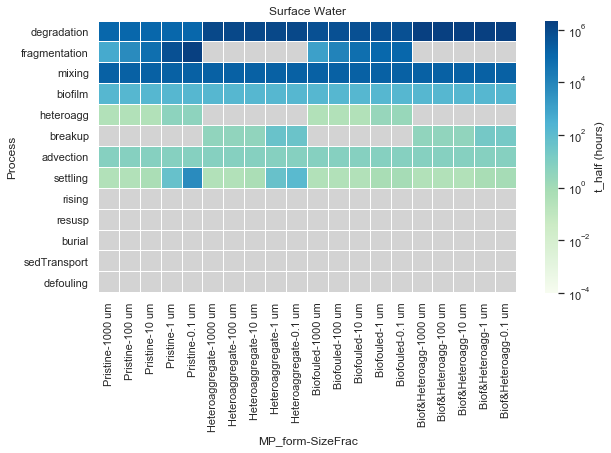

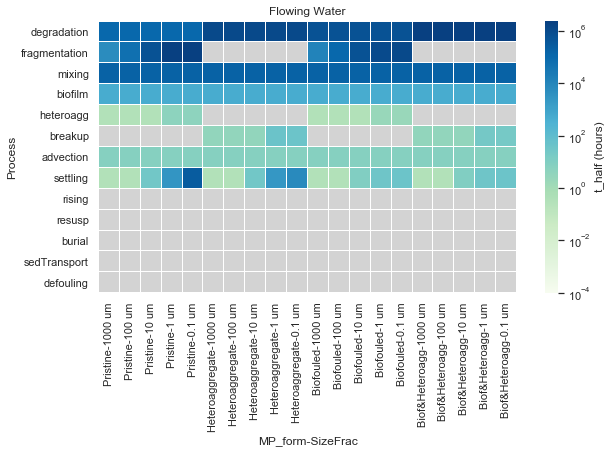

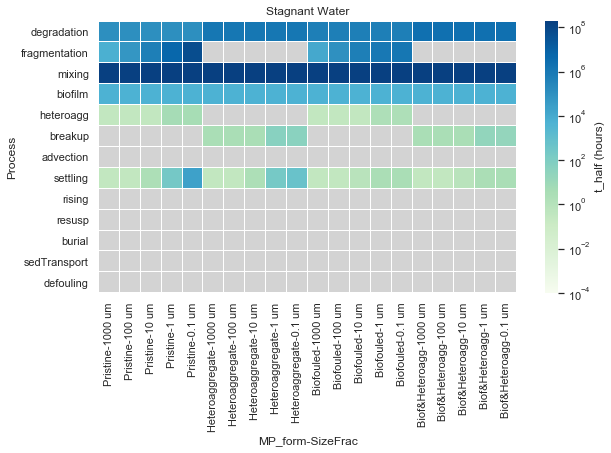

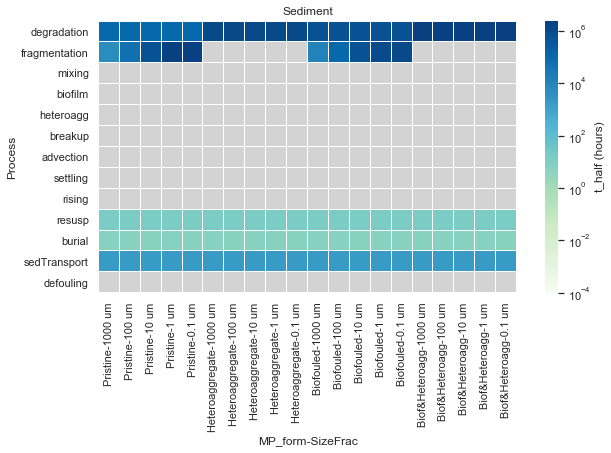

In [23]:
T_hm_array= [Half_life_df_h.loc["Surface Water"],Half_life_df_h.loc["Flowing Water"],Half_life_df_h.loc["Stagnant Water"],Half_life_df_h.loc["Sediment"]]
T_hm_array_ts=[x.transpose() for x in T_hm_array]
T_hm_array_ts=[y.replace(0, 0.0001) for y in T_hm_array_ts]
sns.set(font_scale = 1)
for y in range(len(T_hm_array_ts)):
    T_hm_array_ts[y].index = pd.CategoricalIndex(T_hm_array_ts[y].index, categories= ["degradation", "fragmentation","mixing","biofilm", "heteroagg", "breakup", "advection","settling","rising", "resusp", "burial","sedTransport", "defouling"])
    T_hm_array_ts[y].sort_index(level=0, inplace=True)
    plt.figure(figsize=(10,5))
    log_norm = LogNorm(vmin=T_hm_array_ts[y].min().min(), vmax=T_hm_array_ts[y].max().max())
    ax = sns.heatmap(T_hm_array_ts[y],mask=(T_hm_array_ts[y]==0.0001), annot=False,annot_kws={"size":6}, fmt=".2g", cmap='GnBu',linewidth=0.01, linecolor='white', square=True, robust = True, cbar_kws={'label': 't_half (hours)'},norm=log_norm)
    ax.invert_xaxis()
    ax.set_title(compartments[y])
    # Drawing the frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    ax.set_facecolor('lightgrey')
    plt.show()

## -Generate Interactions Matrix

In [24]:
interactions_df= fillInteractions_fun (RC_df, Clist,compartments_prop)

### Interactions dataframe

In [25]:
interactions_df

,01Aa,01Ab,01Ac,01Ad,01Ae,01Ba,01Bb,01Bc,01Bd,01Be,...,194Ca,194Cb,194Cc,194Cd,194Ce,194Da,194Db,194Dc,194Dd,194De
01Aa,-7.275224e-05,0.000000,0.000000,0.000000,0.000000,0.000046,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ab,3.170979e-07,-0.000072,0.000000,0.000000,0.000000,0.000000,0.000042,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ac,0.000000e+00,0.000003,-0.000908,0.000000,0.000000,0.000000,0.000000,0.000556,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ad,0.000000e+00,0.000000,0.000032,-0.001139,0.000000,0.000000,0.000000,0.000000,0.000556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
01Ae,0.000000e+00,0.000000,0.000000,0.000317,-0.001139,0.000000,0.000000,0.000000,0.000000,0.000556,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194Da,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,-0.00004,0.00000,0.00000,0.00000,0.00000
194Db,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,-0.00004,0.00000,0.00000,0.00000
194Dc,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,-0.00004,0.00000,0.00000
194Dd,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,-0.00004,0.00000


## - SOLVER

In [26]:
#Initial number of particles in the system 
PartNum_t0 = pd.DataFrame(index=Clist, columns=['number of particles'])
for p in range(len(PartNum_t0)):
        PartNum_t0.iloc[p][0]= 0
PartNum_t0.loc["C_"+imputMP]=imputPulse

#Inflow of particles as particles per second 
Ilist = []
for C in Clist:
    Ilist.append("I"+ C[1:])
inflow_vector = pd.DataFrame(index=Ilist, columns=["number of particles"])
inflow_vector.loc[:,:] = 0
inflow_vector.loc["I_"+imputMP] = imputFlow/60 #transformed to particles per sec

#Model funcion
def dNdt_2(N,t,k,I):  
    dNdt=np.dot(N,k)+I
    return np.squeeze(dNdt)

In [27]:
# intitial condition
N0 = PartNum_t0['number of particles'].to_numpy(dtype="float")
I= inflow_vector['number of particles'].to_numpy(dtype="float")
# time points
time = np.linspace(0, tmax, int(timesteps)+1, dtype=int)##in seconds

In [28]:
#Solve ODEs
if SOLVER == 'Dynamic':
    k=interactions_df.to_numpy()
    Nfinal=odeint(dNdt_2, N0, time, args =(k,I), col_deriv=True)
    NFinal_num = pd.DataFrame(data = Nfinal, index=t_span , columns= Clist)  
    
elif SOLVER == "SteadyState":
    print("Steady State not yet implemented")
NFinal_num    

,C_01Aa,C_01Ab,C_01Ac,C_01Ad,C_01Ae,C_01Ba,C_01Bb,C_01Bc,C_01Bd,C_01Be,...,C_194Ca,C_194Cb,C_194Cc,C_194Cd,C_194Ce,C_194Da,C_194Db,C_194Dc,C_194Dd,C_194De
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
86400,4.750101e-09,0.000001,0.000022,0.000498,0.001552,4.980343e-09,0.000001,0.000050,0.0005,0.003585,...,1.647711e-26,1.084131e-24,1.785105e-30,2.229189e-31,1.022072e-31,9.646099e-26,1.475866e-23,3.361888e-28,2.315875e-29,2.479016e-29
172800,6.200875e-09,0.000001,0.000023,0.000498,0.001552,8.426639e-09,0.000002,0.000064,0.0005,0.003585,...,6.734973e-21,3.631601e-19,1.194236e-29,3.075299e-31,1.319549e-31,1.109766e-19,1.109646e-17,2.680833e-27,3.251390e-29,3.432127e-29
259200,7.361100e-09,0.000002,0.000024,0.000498,0.001552,1.116152e-08,0.000004,0.000072,0.0005,0.003585,...,5.423179e-18,2.449244e-16,2.095984e-29,8.922871e-31,1.039417e-31,1.444435e-16,1.052284e-14,4.822230e-27,3.282426e-29,3.532049e-29
345600,8.480504e-09,0.000002,0.000024,0.000498,0.001552,1.417728e-08,0.000005,0.000077,0.0005,0.003585,...,3.152645e-16,1.205925e-14,2.781966e-29,-1.568989e-28,7.519846e-30,1.221132e-14,6.831236e-13,6.329558e-27,2.074022e-28,2.718424e-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31190400,2.281213e-07,0.000010,0.000025,0.000498,0.001552,1.813954e-06,0.000089,0.000083,0.0005,0.003585,...,2.457913e-10,2.650420e-09,3.877115e-29,3.146015e-31,1.344635e-31,3.617895e-08,3.825108e-07,9.062670e-27,3.357029e-29,3.539572e-29
31276800,2.281695e-07,0.000010,0.000025,0.000498,0.001552,1.814423e-06,0.000089,0.000083,0.0005,0.003585,...,2.459876e-10,2.650737e-09,3.877115e-29,3.152635e-31,1.343916e-31,3.620495e-08,3.825529e-07,9.062670e-27,3.356956e-29,3.539580e-29
31363200,2.282171e-07,0.000010,0.000025,0.000498,0.001552,1.814887e-06,0.000089,0.000083,0.0005,0.003585,...,2.461819e-10,2.651047e-09,3.877115e-29,3.153366e-31,1.343838e-31,3.623067e-08,3.825943e-07,9.062670e-27,3.356948e-29,3.539581e-29
31449600,2.282640e-07,0.000010,0.000025,0.000498,0.001552,1.815344e-06,0.000089,0.000083,0.0005,0.003585,...,2.463743e-10,2.651353e-09,3.877115e-29,3.153774e-31,1.343794e-31,3.625613e-08,3.826349e-07,9.062670e-27,3.356944e-29,3.539581e-29


In [29]:
#Vector of volumes corresponding to the compartments of the river
dilution_vol_m3= volumesVector(Clist,compartments_prop)

ConcFinal_num_m3= pd.DataFrame(data = 0, index=t_span , columns= Clist) 
for ind in range(len(NFinal_num)):
    ConcFinal_num_m3.iloc[ind]=NFinal_num.iloc[ind]/dilution_vol_m3

#Substitute values smaller than 10-5 to 0
ConcFinal_num_m3 = ConcFinal_num_m3.apply(lambda x: [y if y >= 1e-15 else 0 for y in x])

### Concentrations dataframe (particle number/m3)

In [30]:
ConcFinal_num_m3

,C_01Aa,C_01Ab,C_01Ac,C_01Ad,C_01Ae,C_01Ba,C_01Bb,C_01Bc,C_01Bd,C_01Be,...,C_194Ca,C_194Cb,C_194Cc,C_194Cd,C_194Ce,C_194Da,C_194Db,C_194Dc,C_194Dd,C_194De
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0
86400,1.187525e-14,2.697095e-12,5.397802e-11,1.244086e-09,3.880766e-09,1.245086e-14,3.101145e-12,1.241859e-10,1.249945e-09,8.961604e-09,...,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0
172800,1.550219e-14,3.280568e-12,5.760789e-11,1.244086e-09,3.880766e-09,2.106660e-14,5.784411e-12,1.605013e-10,1.249945e-09,8.961604e-09,...,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0
259200,1.840275e-14,3.778327e-12,5.964202e-11,1.244086e-09,3.880766e-09,2.790381e-14,9.004537e-12,1.808520e-10,1.249945e-09,8.961604e-09,...,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0
345600,2.120126e-14,4.240520e-12,6.078193e-11,1.244086e-09,3.880766e-09,3.544319e-14,1.263363e-11,1.922563e-10,1.249945e-09,8.961604e-09,...,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31190400,5.703032e-13,2.541944e-11,6.223502e-11,1.244086e-09,3.880766e-09,4.534884e-12,2.222819e-10,2.067939e-10,1.249945e-09,8.961604e-09,...,3.072391e-15,3.313026e-14,0,0,0,4.522369e-13,4.781385e-12,0,0,0
31276800,5.704237e-13,2.541976e-11,6.223502e-11,1.244086e-09,3.880766e-09,4.536058e-12,2.222851e-10,2.067939e-10,1.249945e-09,8.961604e-09,...,3.074845e-15,3.313421e-14,0,0,0,4.525618e-13,4.781911e-12,0,0,0
31363200,5.705427e-13,2.542007e-11,6.223502e-11,1.244086e-09,3.880766e-09,4.537217e-12,2.222882e-10,2.067939e-10,1.249945e-09,8.961604e-09,...,3.077274e-15,3.313809e-14,0,0,0,4.528834e-13,4.782428e-12,0,0,0
31449600,5.706601e-13,2.542038e-11,6.223502e-11,1.244086e-09,3.880766e-09,4.538361e-12,2.222913e-10,2.067939e-10,1.249945e-09,8.961604e-09,...,3.079679e-15,3.314191e-14,0,0,0,4.532017e-13,4.782937e-12,0,0,0


### Concentrations dataframe (mg/m3)

In [31]:
volume= RC_df.loc["volume_m3"].to_numpy()
density= RC_df.loc["density_kg_m3"].to_numpy()
ConcFinal_mg_m3=ConcFinal_num_m3*volume*density*10**6
ConcFinal_mg_m3

,C_01Aa,C_01Ab,C_01Ac,C_01Ad,C_01Ae,C_01Ba,C_01Bb,C_01Bc,C_01Bd,C_01Be,...,C_194Ca,C_194Cb,C_194Cc,C_194Cd,C_194Ce,C_194Da,C_194Db,C_194Dc,C_194Dd,C_194De
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
86400,9.824230e-27,2.231269e-21,4.465526e-17,1.029215e-12,3.210504e-09,1.640114e-24,2.971473e-21,1.027536e-16,1.034062e-12,7.413811e-09,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
172800,1.282474e-26,2.713968e-21,4.765820e-17,1.029215e-12,3.210504e-09,2.775039e-24,5.542540e-21,1.328015e-16,1.034062e-12,7.413811e-09,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
259200,1.522434e-26,3.125757e-21,4.934101e-17,1.029215e-12,3.210504e-09,3.675685e-24,8.628019e-21,1.496400e-16,1.034062e-12,7.413811e-09,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
345600,1.753951e-26,3.508123e-21,5.028405e-17,1.029215e-12,3.210504e-09,4.668825e-24,1.210536e-20,1.590761e-16,1.034062e-12,7.413811e-09,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31190400,4.718039e-25,2.102915e-20,5.148616e-17,1.029215e-12,3.210504e-09,5.973666e-22,2.129874e-19,1.711048e-16,1.034062e-12,7.413811e-09,...,2.300534e-21,3.205059e-20,0.0,0.0,0.0,3.386836e-19,4.626193e-18,0.0,0.0,0.0
31276800,4.719036e-25,2.102941e-20,5.148616e-17,1.029215e-12,3.210504e-09,5.975213e-22,2.129904e-19,1.711048e-16,1.034062e-12,7.413811e-09,...,2.302372e-21,3.205442e-20,0.0,0.0,0.0,3.389270e-19,4.626702e-18,0.0,0.0,0.0
31363200,4.720020e-25,2.102967e-20,5.148616e-17,1.029215e-12,3.210504e-09,5.976739e-22,2.129934e-19,1.711048e-16,1.034062e-12,7.413811e-09,...,2.304191e-21,3.205817e-20,0.0,0.0,0.0,3.391678e-19,4.627203e-18,0.0,0.0,0.0
31449600,4.720991e-25,2.102992e-20,5.148616e-17,1.029215e-12,3.210504e-09,5.978245e-22,2.129963e-19,1.711048e-16,1.034062e-12,7.413811e-09,...,2.305992e-21,3.206187e-20,0.0,0.0,0.0,3.394061e-19,4.627694e-18,0.0,0.0,0.0


# Plot results

## Multyplots graphs: Concentration over time

### Select time span units for plotting (t_span_plot)

In [32]:
t_span_sec = np.linspace(t0, tmax, int(timesteps)+1, dtype=int)
t_span_min=t_span_sec/60
t_span_h = t_span_min/60
t_span_days = t_span_h/24
t_span_months = t_span_days/30

In [33]:
t_span_plot = t_span_months

### Select river sections to plot

In [34]:
RS= ["0","3","5","9","10","12","19"] 

### Select color palette and style

In [35]:
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-white')

### Plot

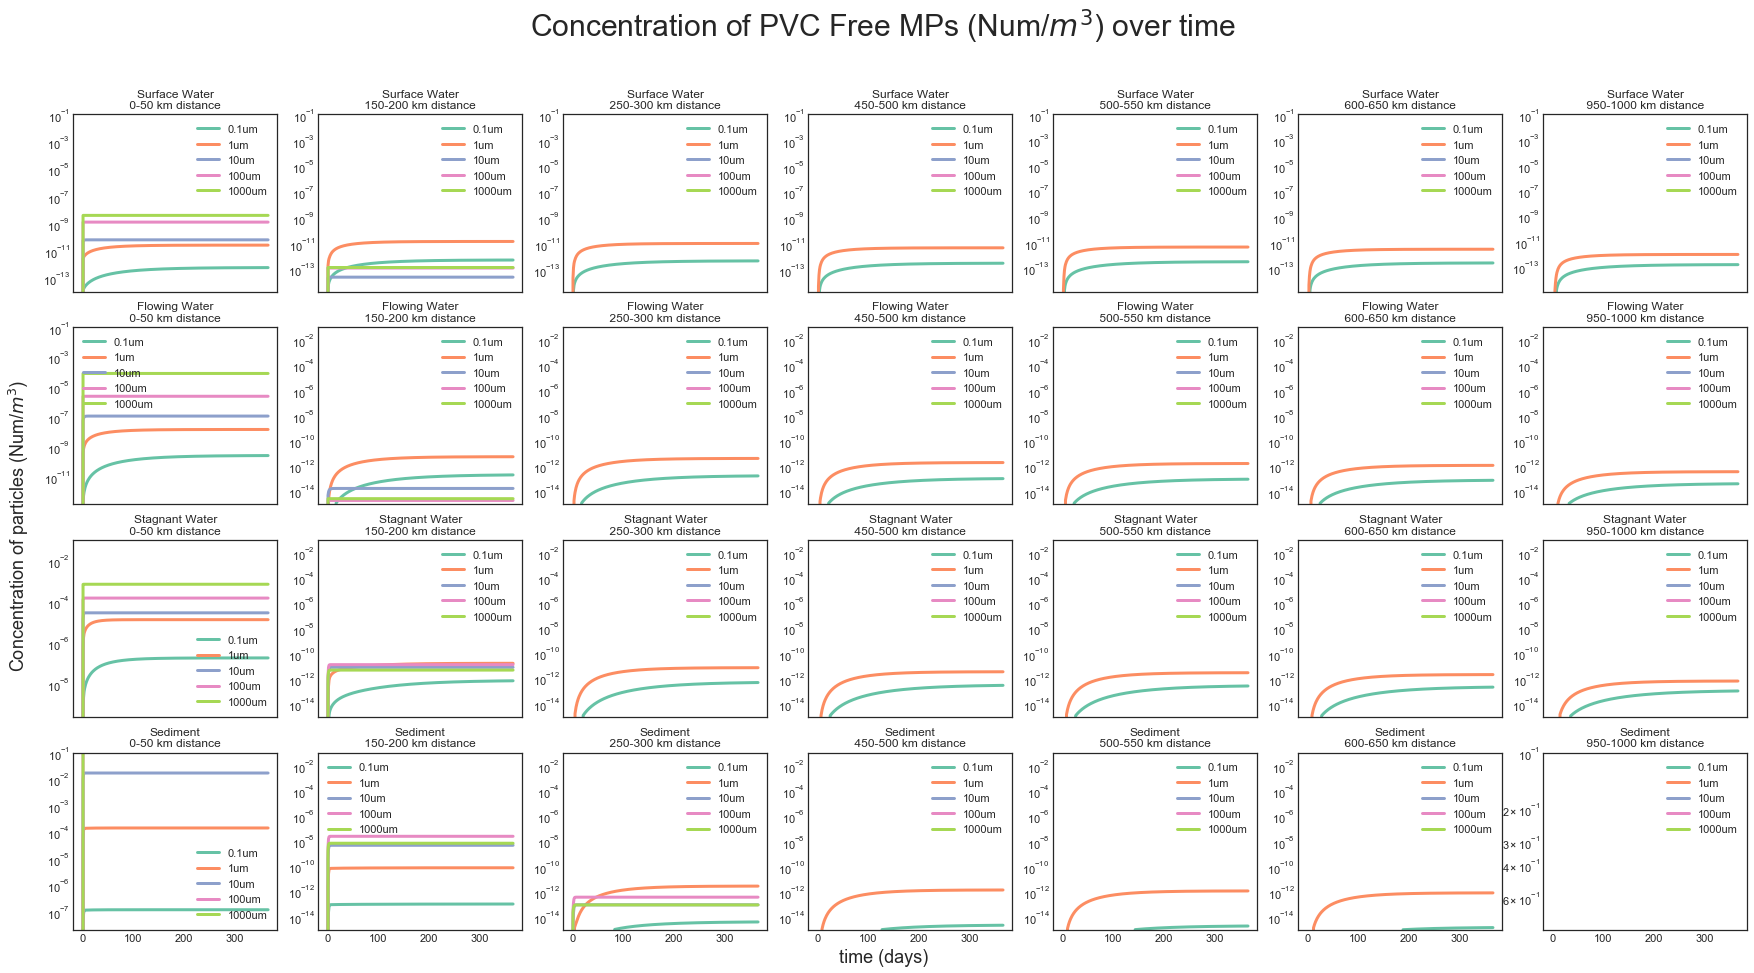

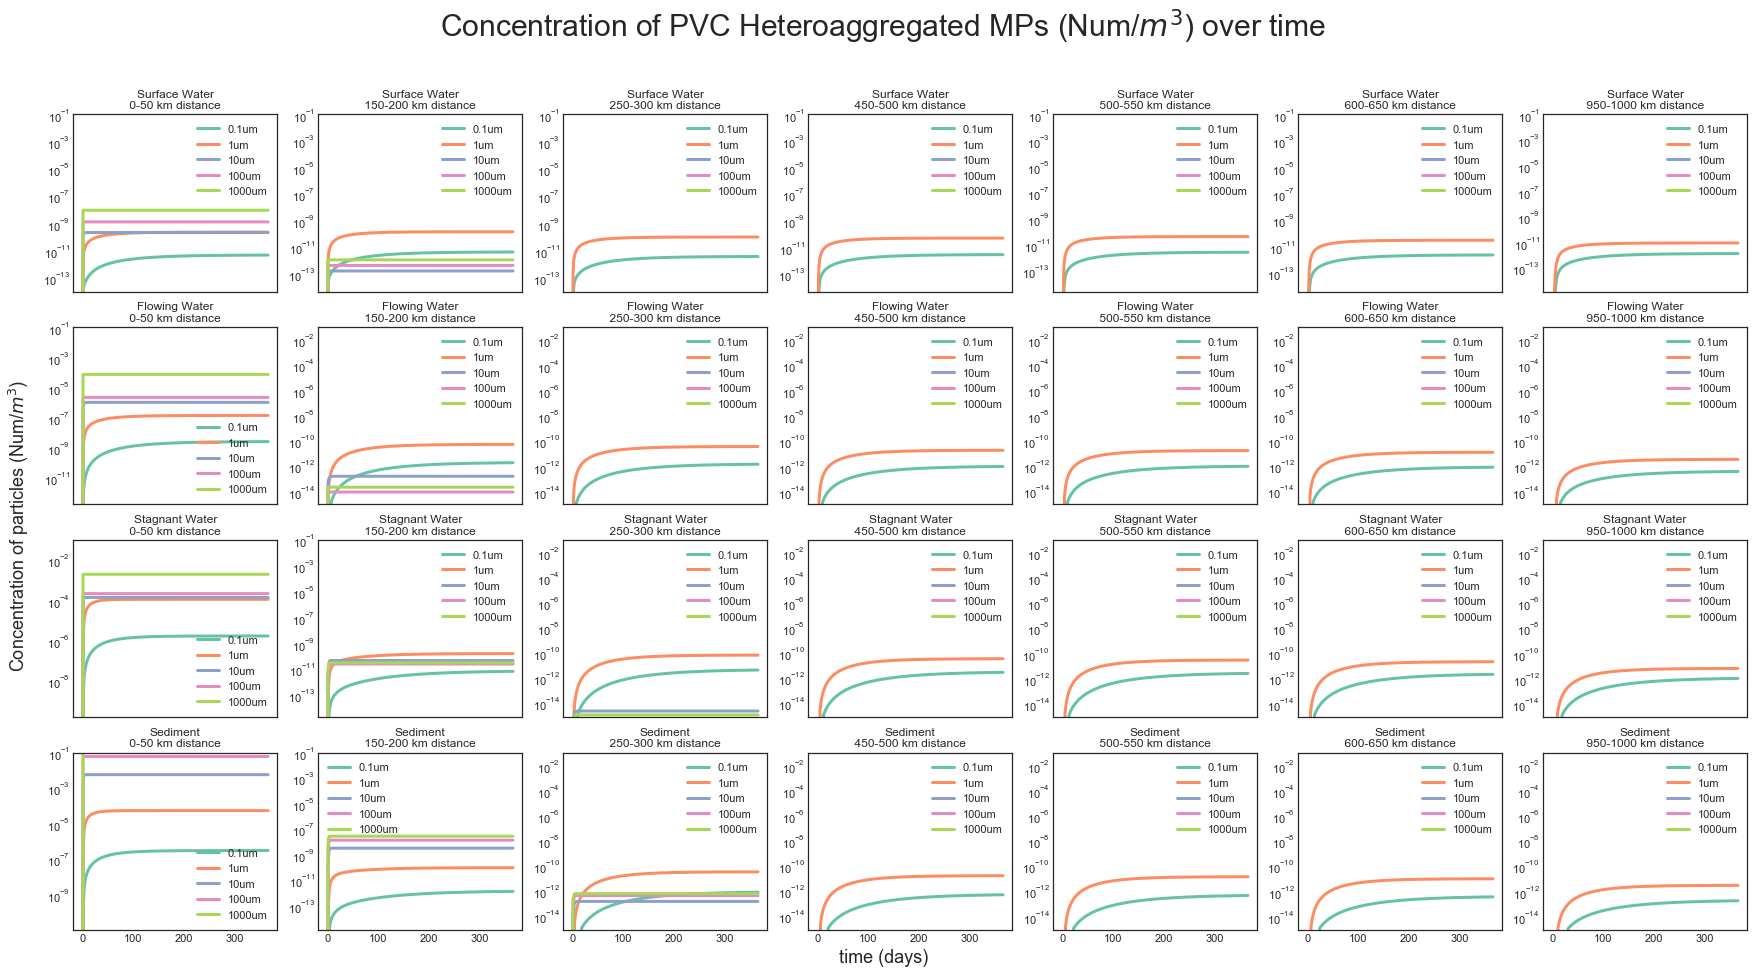

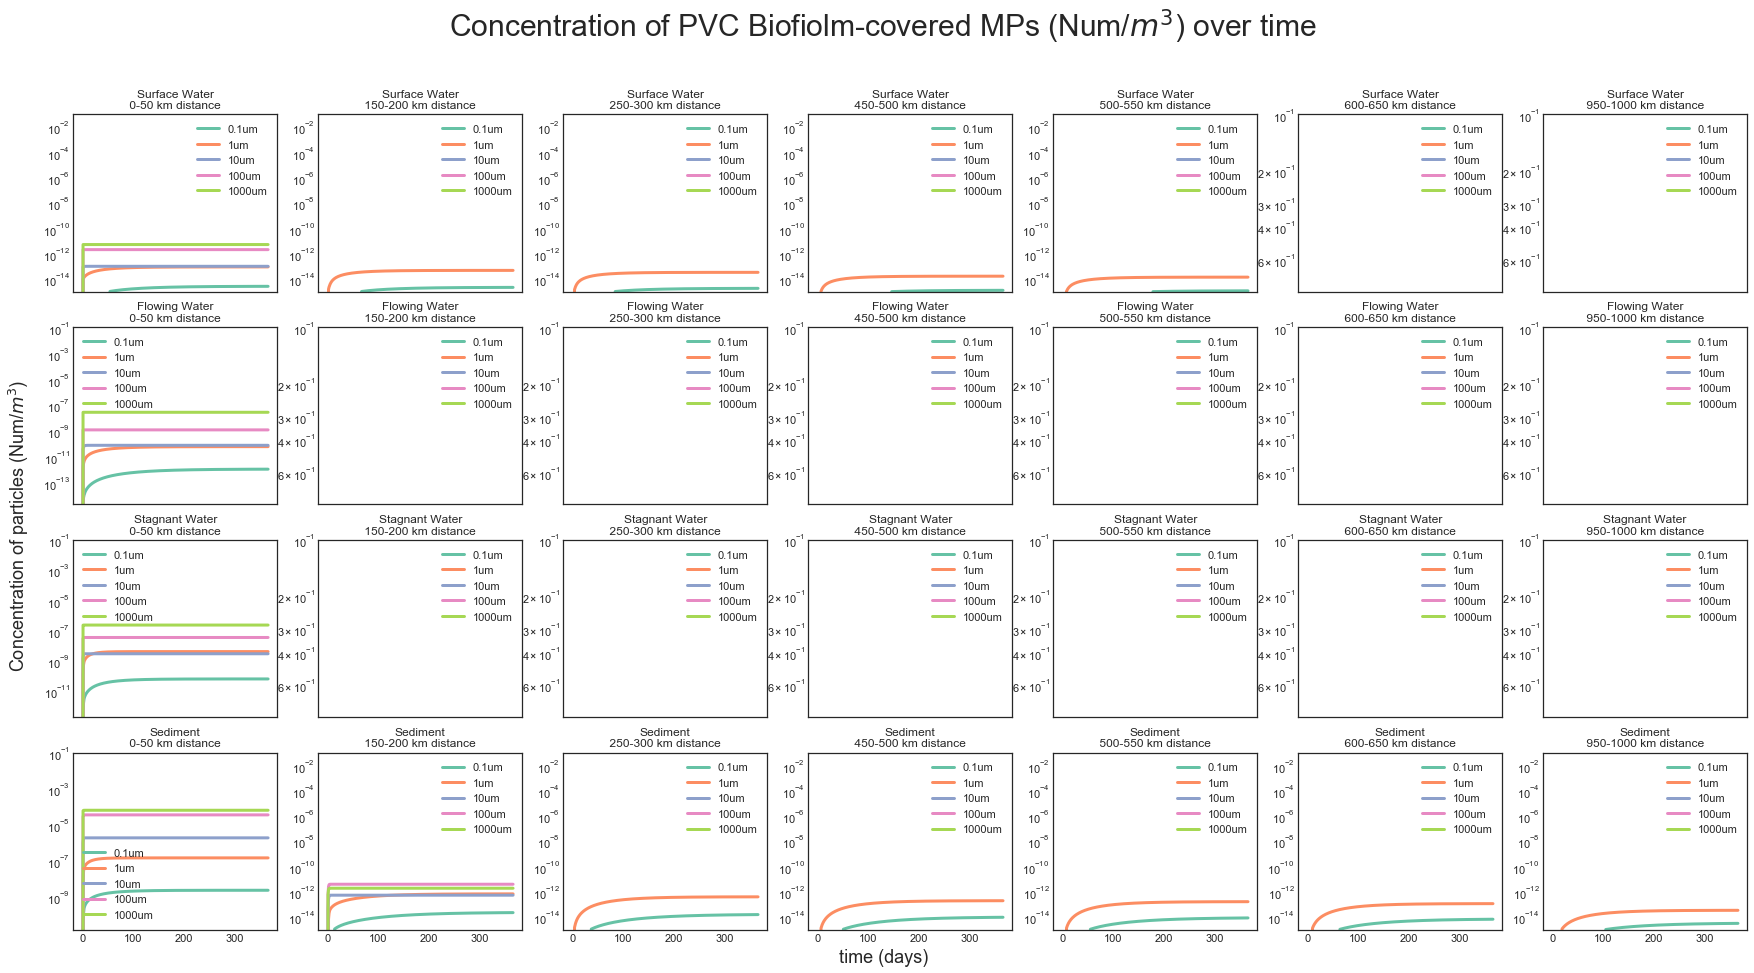

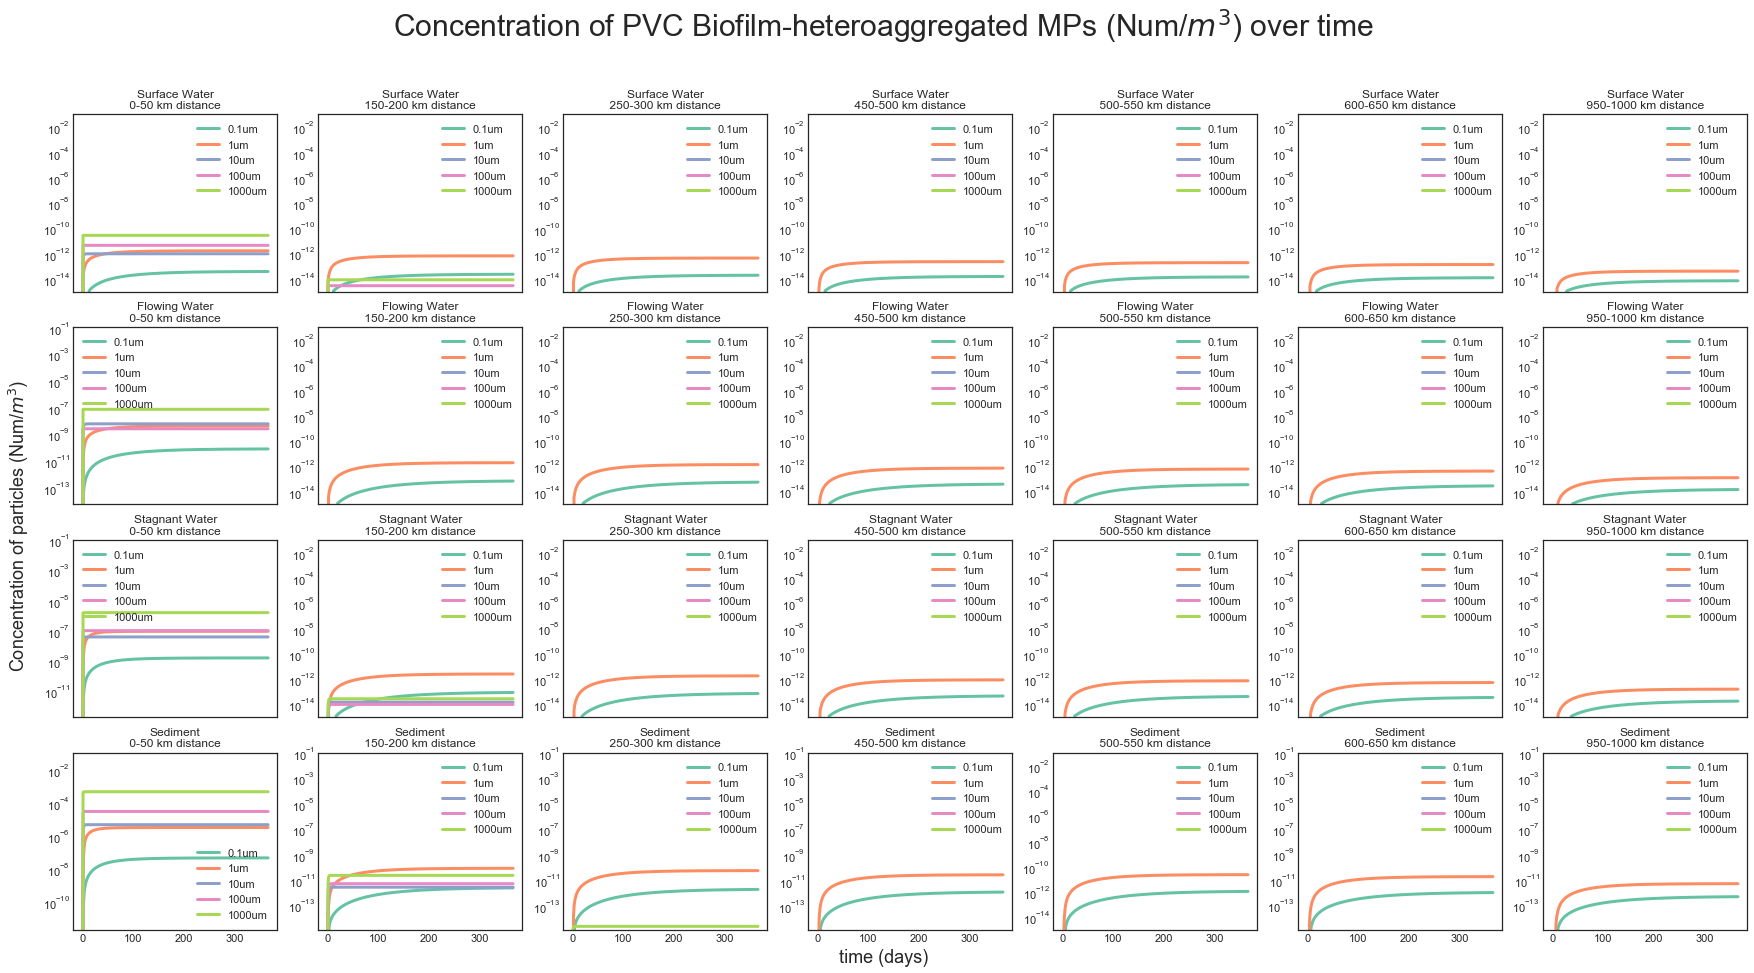

In [37]:
figures=[]
png_labels=[]
for p in range(len(MPforms)):
    fig, axs = plt.subplots(len(compartments),len(RS), figsize=(30, 15),sharex='col')
    fig.suptitle("Concentration of "+ composition +" " + MPformslabels[p]+ " MPs (Num/$m^3$) over time", fontsize=30)
    for i in range(len(RS)):
        for j in range(len(compartments)):
           for k in range(len(sizeBin)):

               axs[j,i].plot(ConcFinal_num_m3.index/60/60/24, ConcFinal_num_m3.loc[:,"C_"+RS[i]+str(j+1)+MPforms[p]+ sizeBin[k]], label= sizeBinLabel[k], color=palette(k), linewidth=3);
               axs[j,i].set_yscale("log")
               axs[j,i].set_ylim(0,1e-1)
               if RS[i] == "0":
                   axs[j,i].set_title(compartments[j]+"\n 0-" + str(int(RS_cumLength_m[int(RS[i])]/1000))+" km distance ", y=1.0)
               else:               
                   axs[j,i].set_title(compartments[j]+"\n "+str(int(RS_cumLength_m[int(RS[i])-1]/1000))+ "-" + str(int(RS_cumLength_m[int(RS[i])]/1000))+" km distance ", y=1.0)

               #axs[j,i].set_yscale('log')
               axs[j,i].legend()
                  

    # Axis titles
    plt.text(0.1, 0.5, "Concentration of particles (Num/$m^3$)", fontsize=18, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
    plt.text(0.5, 0.1, "time (days)", fontsize=18, transform=plt.gcf().transFigure, ha='center', va='center')
    png_label = "Concentration_Num_m3_Multiplot_sizeBins_"+ MPformslabels[p] +"_" +composition+'.png'
    png_labels.append(png_label)
    figures.append(fig)

## Multyplots graphs: Concentration vs distance over time 

### - Organise results for dynamic plotting (GIF)

#### Function to extract concentration values by size fraction

In [38]:
def extract_SizeBins (t, comp, MPform,):
    Aa=[]
    Ab=[]
    Ac=[]
    Ad=[]
    Ae=[]
    for i in range(len(listRS)):
        Aa.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"a")])
        Ab.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"b")])
        Ac.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"c")])
        Ad.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"d")]) 
        Ae.append(ConcFinal_num_m3.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"e")]) 
    return [Aa, Ab, Ac, Ad, Ae]

#### Function to extract lists from a list by criteria

In [39]:
def listofindex(criteria,Clist):                                                                                                             
    lista= [[] for x in range(len(criteria))]
    for i in range(len(lista)):
        lista[i] = [n for n in Clist if criteria[i] in n[-3:]]
    return lista

#### Extract list of indexes needed for plotting

In [40]:
list_of_indexesMpType=listofindex(MPforms,Clist)
list_of_indexesCompartments=listofindex(riverComp,Clist)
list_ofindexesSizeBins=listofindex(sizeBin,Clist)

#### Define time resolution for extracting results (time_extract)

In [41]:
numTstep_hour=(60*60/stepSize)
Time_months=t_span[::(int(numTstep_hour*24*30))]
Time_days=t_span[::(int(numTstep_hour*24))]
Time_halfMonth=t_span[::(int(numTstep_hour*24*15))]
Time_5days=t_span[::(int(numTstep_hour*24*5))]#5 days

In [42]:
time_extract=Time_days

#### Extract data for plotting

#### Set x values (distance in km)

In [43]:
#Distance values
x =[d/1000 for d in RS_cumLength_m]
compartmentsLabel=["Surface\n Water", "Flowing\n Water", "Stagnant\n Water", "Sediment"]

#### Distribution of MPs per aggregation state and compartment over time 


In [44]:
MpTypeNum_t=pd.DataFrame(index=range(len(time_extract)),columns=["Timepoint (min)"]+[m+" (Total number)" for m in MPformslabels]+["Total"])
RelativeAbun_MPtype_t=pd.DataFrame(0, columns=["Timepoint (days)"]+[m+" (%)" for m in MPformslabels], index=MpTypeNum_t.index)
compNum_t=pd.DataFrame(index=range(len(time_extract)),columns=["Timepoint (min)"]+[m+" (Total number)" for m in compartments])
RelativeAbun_Comp=pd.DataFrame(0, columns=["Timepoint (days)"]+[m+" (%)" for m in compartments], index=MpTypeNum_t.index)
for t in range(len(time_extract)):
    #Convert concentration to particle number
    PartNum_timestep=ConcFinal_num_m3.iloc[int(time_extract[t]/stepSize)]*dilution_vol_m3
    MpTypeNum_t.iloc[t,len(MPforms)+1]=sum(PartNum_timestep)
    PartNum_timestep=PartNum_timestep.to_frame()
    for mp in range(1,1+len(MPforms)):
        MpTypeNum_t.iloc[t,mp]=sum(PartNum_timestep.loc[list_of_indexesMpType[mp-1], :][time_extract[t]].to_list())
        if MpTypeNum_t.iloc[t,len(MPforms)+1] == 0:
            RelativeAbun_MPtype_t.iloc[t,mp]= 0
        else:
            RelativeAbun_MPtype_t.iloc[t,mp]=round((MpTypeNum_t.iloc[t,mp]/MpTypeNum_t.iloc[t,len(MPforms)+1])*100,2)
    for com in range(1,1+len(compartments)):
        compNum_t.iloc[t,com]=sum(PartNum_timestep.loc[list_of_indexesCompartments[com-1], :][time_extract[t]].to_list())
        if MpTypeNum_t.iloc[t,len(MPforms)+1]== 0:
            RelativeAbun_Comp.iloc[t,com]=0
        else:
            RelativeAbun_Comp.iloc[t,com]=round((compNum_t.iloc[t,com]/MpTypeNum_t.iloc[t,len(MPforms)+1])*100,2)
    RelativeAbun_MPtype_t.iloc[t,0]=t
    MpTypeNum_t.iloc[t,0]=time_extract[t]/stepSize
    compNum_t.iloc[t,0]=time_extract[t]/stepSize
    RelativeAbun_Comp.iloc[t,0]=t

#### - Relative abundance of MPs aggregation states in the whole system per time step

In [45]:
RelativeAbun_MPtype_t

,Timepoint (days),Free (%),Heteroaggregated (%),Biofiolm-covered (%),Biofilm-heteroaggregated (%)
0,0,0.00,0.00,0.00,0.00
1,1,38.99,60.95,0.01,0.05
2,2,39.54,60.40,0.01,0.05
3,3,39.52,60.42,0.01,0.05
4,4,39.50,60.44,0.01,0.05
...,...,...,...,...,...
361,361,39.44,60.51,0.01,0.05
362,362,39.44,60.51,0.01,0.05
363,363,39.44,60.51,0.01,0.05
364,364,39.44,60.51,0.01,0.05


#### - Fractionation of MPs per compartmet over time for the whole system

In [46]:
RelativeAbun_Comp

,Timepoint (days),Surface Water (%),Flowing Water (%),Stagnant Water (%),Sediment (%)
0,0,0.0,0.00,0.00,0.00
1,1,0.0,4.02,6.05,89.93
2,2,0.0,3.51,5.67,90.83
3,3,0.0,3.45,5.65,90.89
4,4,0.0,3.45,5.66,90.89
...,...,...,...,...,...
361,361,0.0,3.45,5.85,90.71
362,362,0.0,3.45,5.85,90.71
363,363,0.0,3.45,5.85,90.71
364,364,0.0,3.45,5.85,90.71


#### - Relative abundance per size fraction after 1 year run

In [47]:
#Define time step (1year)
time=range(len(t_span))
t=time[-1]# last time step 

In [48]:
# Estimate total number of particles per size fraction in each compartment
SizeFracNum_comp=pd.DataFrame(index=sizeBinLabel,columns= compartments)
for siz in range(len(sizeBin)):
    for co in range(len(SizeFracNum_comp.columns)):  
        list_sb= [n for n in list_of_indexesCompartments[co] if sizeBin[siz] in n[-3:]]
        SizeFracNum_comp.iloc[siz,co]=sum(NFinal_num[list_sb].iloc[t].to_list())

In [49]:
Total_num_water=sum(sum(SizeFracNum_comp[compartments[0:3]].values))
Total_num_sediment=sum(SizeFracNum_comp[compartments[-1]].values)
RelativeAbun_SizeFrac=pd.DataFrame(index=sizeBinLabel,columns=["Relative abundance in water (%)", "Relative abundance in sediment (%)"])
for siz in range(len(sizeBin)):
    if sum(SizeFracNum_comp.iloc[siz][compartments[0:3]].values)==0:
        RelativeAbun_SizeFrac.iloc[siz,0]=0
    else:
        RelativeAbun_SizeFrac.iloc[siz,0]=round((sum(SizeFracNum_comp.iloc[siz][compartments[0:3]].values)/Total_num_water)*100,2)
    if SizeFracNum_comp.iloc[siz][compartments[-1]]==0:
        RelativeAbun_SizeFrac.iloc[siz,1]=0
    else:
        RelativeAbun_SizeFrac.iloc[siz,1]=round((SizeFracNum_comp.iloc[siz][compartments[-1]]/Total_num_sediment)*100,2)
RelativeAbun_SizeFrac

,Relative abundance in water (%),Relative abundance in sediment (%)
0.1um,0.04,0
1um,2.43,0.02
10um,3.45,2.21
100um,7.95,25.11
1000um,86.12,72.66


### PLOT

#### Choose style and colour palette

In [50]:
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-white')
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='ivory', alpha=0.5)
props2 = dict(boxstyle='round', facecolor='white', alpha=0.5)

#### Static plot (t=tfinal)

In [51]:
t=len(time_extract)-1

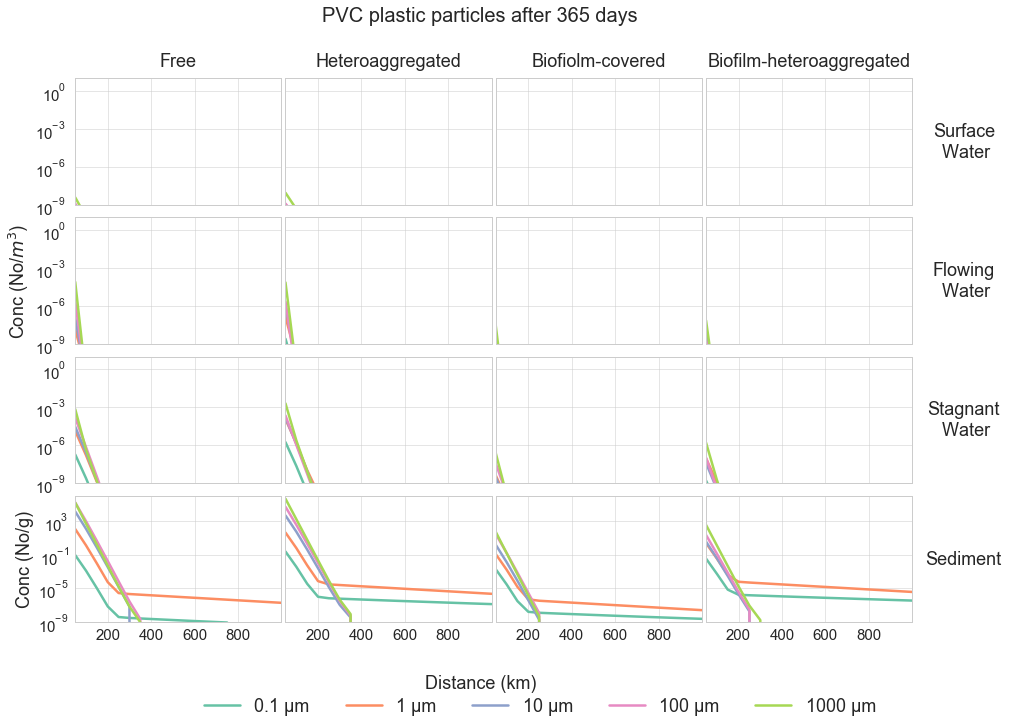

In [52]:
import matplotlib.ticker as ticker
from matplotlib import ticker
plt.style.use('seaborn-whitegrid')

fig2, axs = plt.subplots(len(compartments),len(MPforms), figsize=(15, 10),sharex='col', sharey= "row", squeeze="True")
labels = ['0.1 \u03BCm', '1 \u03BCm', '10 \u03BCm', '100 \u03BCm', '1000 \u03BCm']
if imputFlow == 0:
    fig2.suptitle( composition +" plastic particles fate along the generic river (pulse= "+ str(imputPulse)+" particles of 1mm)", fontsize=20, y=0.98)
else:
    fig2.suptitle( composition +" plastic particles after "+str(int(time_extract[t]/60/60/24)) + " days" , fontsize=20,  y=0.98)

for j in range(len(compartments)):
    if j == 3:
        for k in range(len(MPforms)):
            #Plot
            y = extract_SizeBins (t, riverComp[j], MPforms[k])
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[0]], linewidth=2.5,color=palette(0), label='0.1 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[1]], linewidth=2.5,color=palette(1), label='1 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[2]], linewidth=2.5,color=palette(2), label='10 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[3]], linewidth=2.5,color=palette(3), label='100 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[4]], linewidth=2.5,color=palette(4), label='1000 \u03BCm')
            
            if k==3:
                axs[j,k].text(1.25, 0.5, compartmentsLabel[j] ,fontsize=18,rotation=0, va='center',ha='center', transform=axs[j,k].transAxes)

            axs[j,k].set_yscale('log')
            axs[j,k].set_ylim(10**-9,1000000)
            if k == 0:
                axs[j,k].set_ylabel("Conc (No/g)", fontsize=18)
            axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            #axs[j,k].set_xlim(x[0],x[-1])
            axs[j,k].set_xticks([200,400,600,800])
            axs[j,k].tick_params(axis='x', labelsize=15, direction='inout', length=6, width=1, grid_alpha=0.5)
            axs[j,k].tick_params(axis='y',labelsize=15, direction='inout', length=6, width=1, grid_alpha=0.5) 
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-1,1))
            
    else:
        for k in range(len(MPforms)):
            #Plot
            y = extract_SizeBins (t, riverComp[j], MPforms[k])
            axs[j,k].plot(x, y[0], linewidth=2.5,color=palette(0), label='0.1 \u03BCm')
            axs[j,k].plot(x, y[1], linewidth=2.5,color=palette(1), label='1 \u03BCm')
            axs[j,k].plot(x, y[2], linewidth=2.5,color=palette(2), label='10 \u03BCm')
            axs[j,k].plot(x, y[3], linewidth=2.5,color=palette(3), label='100 \u03BCm')
            axs[j,k].plot(x, y[4], linewidth=2.5,color=palette(4), label='1000 \u03BCm')
            if j== 0:
                axs[j,k].text(0.5,1.1, MPformslabels[k] ,fontsize=18, transform= axs[j,k].transAxes, ha='center')        
            if k==3:
                axs[j,k].text(1.25, 0.5, compartmentsLabel[j] ,fontsize=18,rotation=0, va='center',ha='center', transform=axs[j,k].transAxes)
            if k == 0:
                if j==1:
                    axs[j,k].set_ylabel("Conc (No/$m^3$)", fontsize=18)
            axs[j,k].set_yscale('log')
            
            if j==0:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            elif j==1:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            elif j== 2:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            axs[j,k].set_xlim(x[0],x[-1])

            axs[j,k].tick_params(axis='x', labelsize=15, direction='out', length=6, width=1, grid_alpha=0.5)
            axs[j,k].tick_params(axis='y',labelsize=15, direction='out', length=6, width=1, grid_alpha=0.5)
            from matplotlib import ticker
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-1,1)) 
            axs[j,k].minorticks_on()
            
           
# Axis titles
#plt.text(0.02, 0.5, "Concentration of particles (Num/$m^3$)", fontsize=15, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
plt.text(0.5, 0.04, "Distance (km)", fontsize=18, transform=plt.gcf().transFigure, ha='center', va='center')
#plt.legend(labels,bbox_to_anchor=(0.5, -0.18), loc='center',ncol=5, fontsize=15 )
plt.subplots_adjust(wspace=0.02,hspace=0.1)
handles, labels = axs[j,k].get_legend_handles_labels()
fig2.legend(handles, labels, bbox_to_anchor=(0.5, 0.02), loc='center',ncol=5, fontsize=18)        
fig2_label= "ConcvsDist_Num_m3_Multiplot_"+ composition +".png"

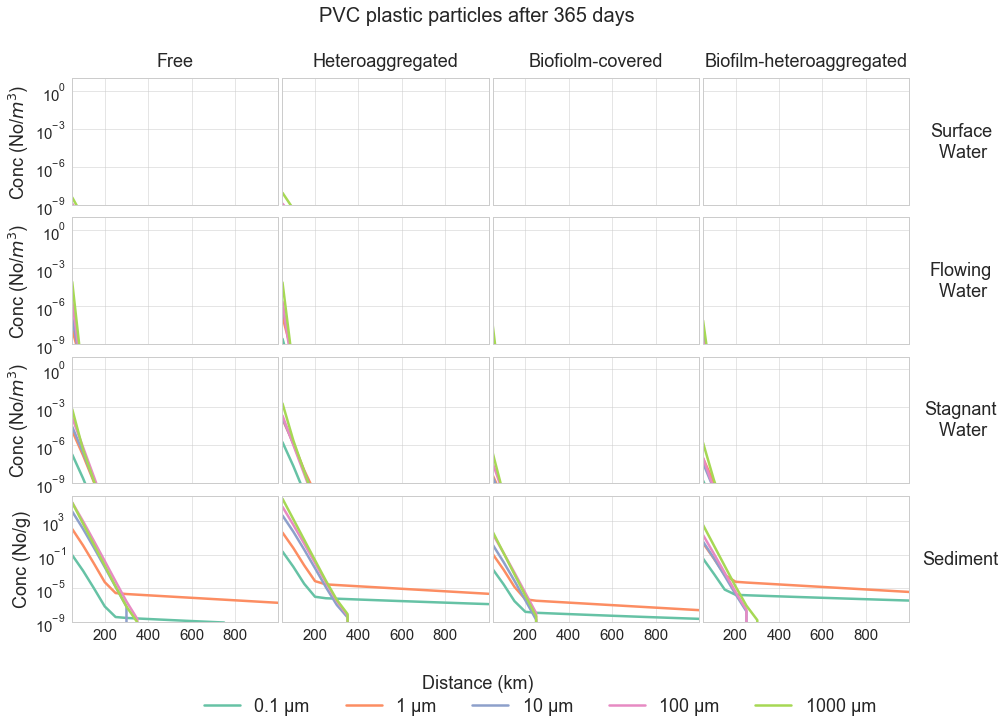

In [55]:
import matplotlib.ticker as ticker
from matplotlib import ticker
plt.style.use('seaborn-whitegrid')

fig2, axs = plt.subplots(len(compartments),len(MPforms), figsize=(15, 10),sharex='col', sharey= "row", squeeze="True")

labels = ['0.1 \u03BCm', '1 \u03BCm', '10 \u03BCm', '100 \u03BCm', '1000 \u03BCm']
if imputFlow == 0:
    fig2.suptitle( composition +" plastic particles fate along the generic river (pulse= "+ str(imputPulse)+" particles of 1mm)", fontsize=20, y=0.98)
else:
    fig2.suptitle( composition +" plastic particles after "+str(int(time_extract[t]/60/60/24)) + " days" , fontsize=20, y=0.98)

for j in range(len(compartments)):
    if j == 3:
        for k in range(len(MPforms)):
            #Plot
            y = extract_SizeBins (t, riverComp[j], MPforms[k])
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[0]], linewidth=2.5,color=palette(0), label='0.1 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[1]], linewidth=2.5,color=palette(1), label='1 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[2]], linewidth=2.5,color=palette(2), label='10 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[3]], linewidth=2.5,color=palette(3), label='100 \u03BCm')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[4]], linewidth=2.5,color=palette(4), label='1000 \u03BCm')

            if k==3:
                axs[j,k].text(1.25, 0.5, compartmentsLabel[j] ,fontsize=18,rotation=0, va='center',ha='center', transform=axs[j,k].transAxes)

            axs[j,k].set_yscale('log')
            axs[j,k].set_ylim(10**-9,1000000)
            if k == 0:
                axs[j,k].set_ylabel("Conc (No/g)", fontsize=18)
            axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            axs[j,k].set_xticks([200,400,600,800])
            axs[j,k].set_xlim(x[0],x[-1])
            axs[j,k].tick_params(axis='x', labelsize=15, direction='inout', length=6, width=1, grid_alpha=0.5)
            axs[j,k].tick_params(axis='y',labelsize=15, direction='inout', length=6, width=1, grid_alpha=0.5) 
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-1,1)) 
    else:
        for k in range(len(MPforms)):
            #Plot
            y = extract_SizeBins (t, riverComp[j], MPforms[k])
            axs[j,k].plot(x, y[0], linewidth=2.5,color=palette(0), label='0.1 \u03BCm')
            axs[j,k].plot(x, y[1], linewidth=2.5,color=palette(1), label='1 \u03BCm')
            axs[j,k].plot(x, y[2], linewidth=2.5,color=palette(2), label='10 \u03BCm')
            axs[j,k].plot(x, y[3], linewidth=2.5,color=palette(3), label='100 \u03BCm')
            axs[j,k].plot(x, y[4], linewidth=2.5,color=palette(4), label='1000 \u03BCm')
            if j== 0:
                axs[j,k].text(0.5,1.1, MPformslabels[k],fontsize=18, transform= axs[j,k].transAxes, ha='center')        
            if k==3:
                axs[j,k].text(1.25, 0.5, compartmentsLabel[j] ,fontsize=18,rotation=0, va='center',ha='center', transform=axs[j,k].transAxes)
            if k == 0:
                axs[j,k].set_ylabel("Conc (No/$m^3$)", fontsize=18)
            axs[j,k].set_yscale('log')
            
            if j==0:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            elif j==1:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            elif j== 2:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            axs[j,k].set_xlim(x[0],x[-1])

            axs[j,k].tick_params(axis='x', labelsize=15, direction='inout', length=6, width=1, grid_alpha=0.5)
            axs[j,k].tick_params(axis='y',labelsize=15, direction='inout', length=6, width=1, grid_alpha=0.5)
            from matplotlib import ticker
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-1,1)) 
            axs[j,k].minorticks_on()
            
           
# Axis titles
#plt.text(0.02, 0.5, "Concentration of particles (Num/$m^3$)", fontsize=15, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
plt.text(0.5, 0.04, "Distance (km)", fontsize=18, transform=plt.gcf().transFigure, ha='center', va='center')
#plt.legend(labels,bbox_to_anchor=(0.5, -0.18), loc='center',ncol=5, fontsize=15 )
plt.subplots_adjust(wspace=0.02,hspace=0.1)
handles, labels = axs[j,k].get_legend_handles_labels()
fig2.legend(handles, labels, bbox_to_anchor=(0.5, 0.02), loc='center',ncol=5, fontsize=18)        
fig2_label= "ConcvsDist_Num_m3_Multiplot_"+ composition +".png"

# Save results

### Create results and figures folders

In [17]:
os.chdir(cwd+"/Results")
    
#create folder for the day if it doesnt already exists

path = cwd+"/Results"
os.path.isdir(path)
old_path = (daterun_label)
new_path = os.path.isdir(old_path)
if not new_path:
    os.makedirs(old_path)
    print("Created Folder : ", old_path)
else:
    print(old_path, "folder already exists.")

results_path= cwd+"/Results/"+old_path

os.chdir(results_path)

Fig_folder= "/Figures"
os.path.isdir(results_path+Fig_folder)

new_path = os.path.isdir(results_path+Fig_folder)
if not new_path:
    os.mkdir("Figures")
    print("Created Folder : ", Fig_folder)
else:
    print(Fig_folder, "folder already exists.")

results_figures_path= results_path+Fig_folder

2021_07_26 folder already exists.
/Figures folder already exists.


### Save results and figures

In [71]:
if record == "True":   
    os.chdir(cwd+"/Results")
    
    #create folder for the day if it doesnt already exists
    path = cwd+"/Results"
    os.path.isdir(path)
    old_path = (daterun_label)
    new_path = os.path.isdir(old_path)
    if not new_path:
        os.makedirs(old_path)
        print("Created Folder : ", old_path)
    else:
        print(old_path, "folder already exists.")
    
    results_path= cwd+"/Results/"+old_path
    
    os.chdir(results_path)
    #save
    #rate constants 
    dfRC_filename = "RC_df" + runtitle +"_"+ daterun_label + ".csv"
    RC_df_final.to_csv(dfRC_filename)
    
    #interactions dataframe to results folder
    interactions_filename = "interactionsdf_"+ runtitle +"_"+  daterun_label + ".csv"
    interactions_df.to_csv(interactions_filename)
    
    #Results
    filename= "ConcVStime_particleNum_m3_"+ runtitle +"_"+ daterun_label+".csv"
    filename1= "MassVStime_kg_"+ runtitle +"_"+ daterun_label+".csv"
    ConcFinal_num_m3.to_csv(filename)
    ConcFinal_mg_m3.to_csv(filename1)
    RelativeAbun_MPtype_t.to_csv("Relative_abundance_MPtype_"+composition+daterun_label+".csv")  
    RelativeAbun_Comp.to_csv("Relative_abundance_Compartment_"+composition+daterun_label+".csv")  
    

    #back to working directory
    os.chdir(cwd)
    
    #Save figures
    os.chdir(results_figures_path)
    for f in range(len(figures)):
        figg=figures[f]
        figg_name=png_labels[f]
        figg.savefig(figg_name)
    fig2.savefig(fig2_label)


2021_07_07 folder already exists.
